<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Communication Systems
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. Pakravan
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>

<hr>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @YadollahiAlii
</font>
<br>
<hr>
</div></font>

<div align="center">
<font face="Calibri" size="5">
Kiarash Gheisari Pour
<br>
402102302
</font>
</div>

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz
from scipy.fft import fft, ifft, fftshift, fftfreq
from numpy.linalg import pinv
import scipy.stats as stats

# add your libraries

# Question 1

In communication systems, short bursts or transients (like pulses or chirps) are used to probe or transmit through channels.  
We define a causal signal that starts at time \(T_0\), then decays exponentially with oscillations.


$x(t) = (t - T_0)^3 e^{-(t - T_0)/\tau} \cos(2\pi f_0 (t - T_0)) u(t - T_0)$


---

## Task 1.1
1. Generate and plot \(x(t)\) for $(0 \le t \le 100\,s)$ in $0.01$ second increments..  
2. Identify:
   - The time when the signal reaches its maximum amplitude.
   - The approximate pulse duration (where it is non-negligible).
3. Compute and plot the **magnitude spectrum** |X(f)|.  
4. Estimate the **3 dB bandwidth** of the main lobe.

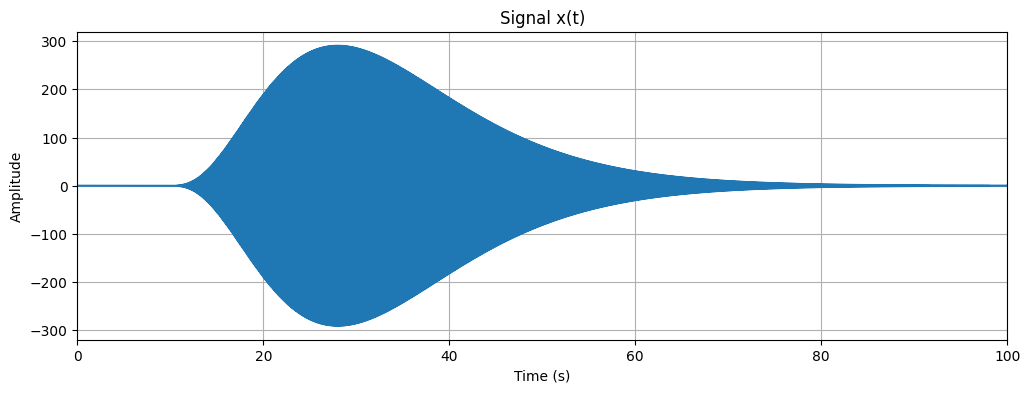

Maximum amplitude: 290.3582 at t = 28.00 s
Pulse duration (> 1% of max): 68.50 s (from 11.60 to 80.10 s)


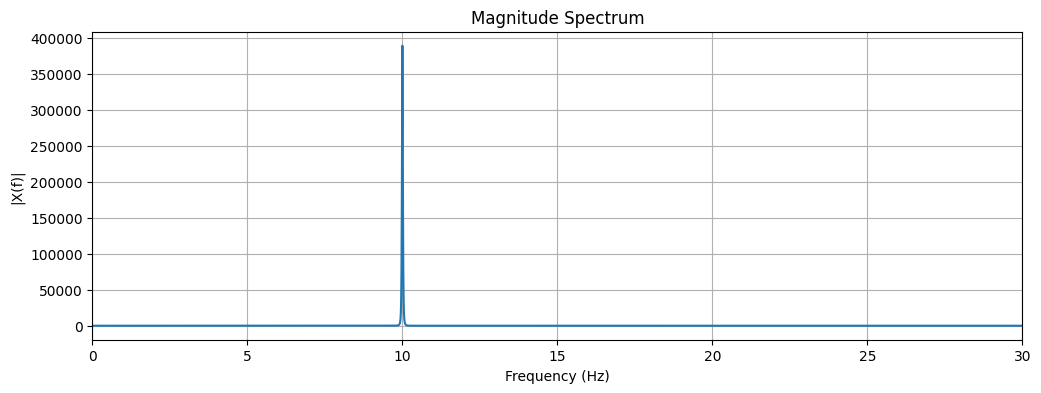

3 dB Bandwidth: 0.03 Hz (from 9.98 to 10.01 Hz)


In [2]:
# Task 1.1
dt = 0.01
t = np.arange(0, 100, dt)
T0, f0, tau = 10.0, 10.0, 6.0

# signal generation
x = np.zeros_like(t)
mask = t >= T0
t_shifted = t[mask] - T0
x[mask] = (t_shifted**3) * np.exp(-t_shifted/tau) * np.cos(2*np.pi*f0*t_shifted)

# plot x(t)
plt.figure(figsize=(12, 4))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal x(t)')
plt.grid(True)
plt.xlim(0, 100)
plt.show()

# max amplitude and time
max_idx = np.argmax(np.abs(x))
t_max = t[max_idx]
x_max = x[max_idx]
print(f"Maximum amplitude: {x_max:.4f} at t = {t_max:.2f} s")

# pulse duration (threshold at 1% of max)
threshold = 0.01 * np.abs(x_max)
significant = np.abs(x) > threshold
if np.any(significant):
    pulse_start = t[significant][0]
    pulse_end = t[significant][-1]
    pulse_duration = pulse_end - pulse_start
    print(f"Pulse duration (> 1% of max): {pulse_duration:.2f} s (from {pulse_start:.2f} to {pulse_end:.2f} s)")

# magnitude spectrum
X = fft(x)
N = len(x)
f = fftfreq(N, dt)
X_mag = np.abs(X)

# positive frequencies only
pos_freq_mask = f >= 0
f_pos = f[pos_freq_mask]
X_mag_pos = X_mag[pos_freq_mask]

plt.figure(figsize=(12, 4))
plt.plot(f_pos, X_mag_pos)
plt.xlabel('Frequency (Hz)')
plt.ylabel('|X(f)|')
plt.title('Magnitude Spectrum')
plt.grid(True)
plt.xlim(0, 30)
plt.show()

# 3 dB bandwidth calculation
X_mag_max = np.max(X_mag_pos)
threshold_3dB = X_mag_max / np.sqrt(2)

above_threshold = X_mag_pos > threshold_3dB
freq_indices = np.where(above_threshold)[0]

if len(freq_indices) > 0:
    diff = np.diff(above_threshold.astype(int))
    crossings = np.where(diff != 0)[0]
    
    if len(crossings) >= 2:
        f_lower = f_pos[crossings[0]]
        f_upper = f_pos[crossings[1]]
        bandwidth_3dB = f_upper - f_lower
    else:
        f_lower = f_pos[freq_indices[0]]
        f_upper = f_pos[freq_indices[-1]]
        bandwidth_3dB = f_upper - f_lower
    
    print(f"3 dB Bandwidth: {bandwidth_3dB:.2f} Hz (from {f_lower:.2f} to {f_upper:.2f} Hz)")

## Task 1.2

A **frequency-selective channel** affects each frequency component differently.  
Some frequencies may be amplified or attenuated, leading to waveform distortion.

We define:

$
H(f) = [1 + k \cos(2\pi f T_0)] [1 + r e^{-(f - f_c)^2 / (2f_w^2)}] e^{-j2\pi f t_d}, \quad |f|\le B
$

$
H(f) = 0, \quad |f|> B
$

---
1. Implement $H(f)$.  
2. Compute $y(t) = \text{IFFT}(H(f)X(f))$.  
3. Plot $x(t)$ and $y(t)$ together.  
4. Discuss how the channel alters amplitude and timing.


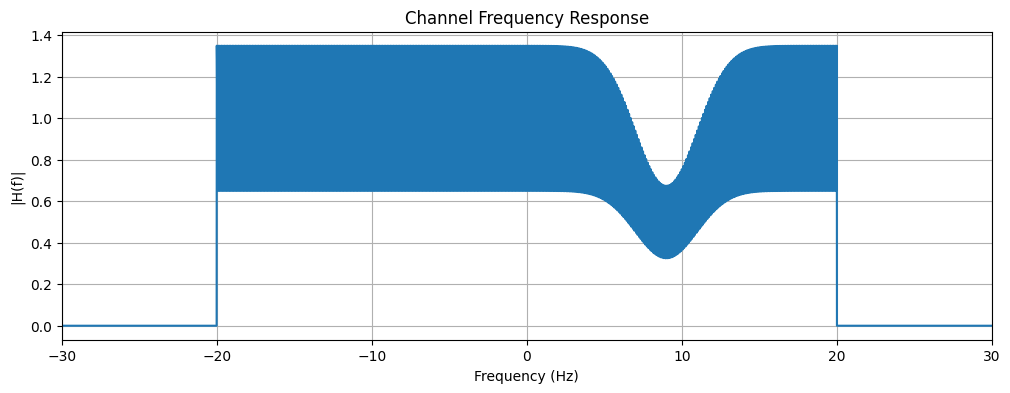

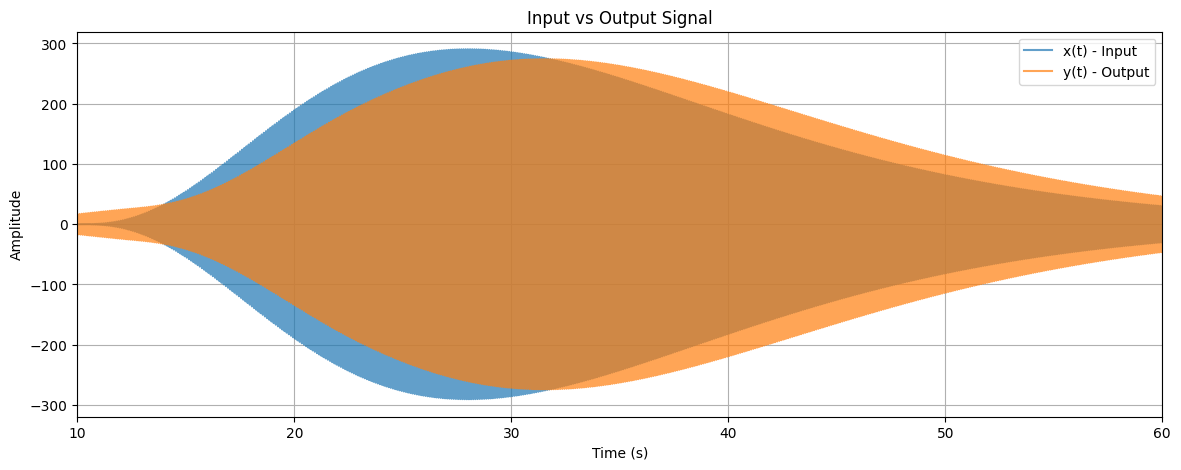

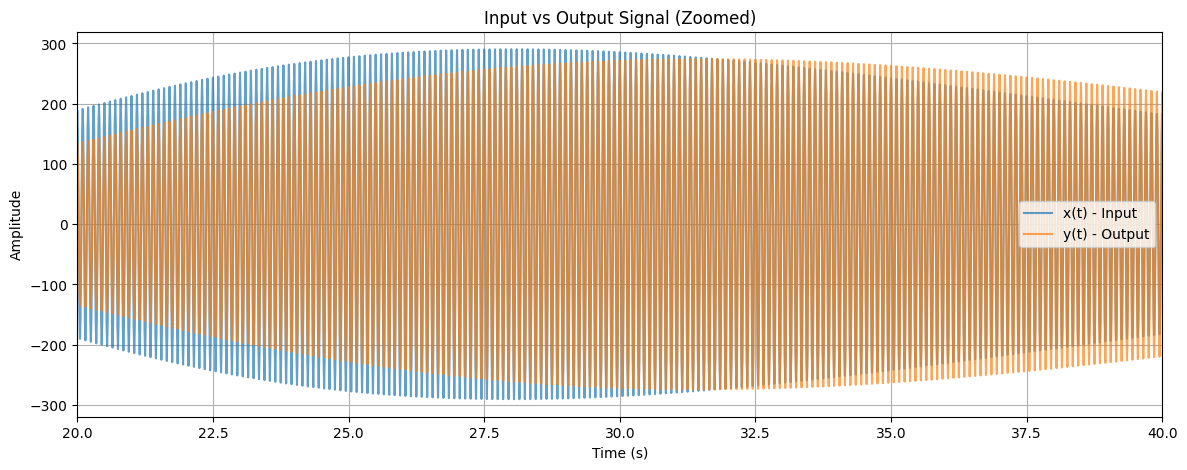

In [3]:
# Task 1.2
k, td, B = 0.35, T0/4, 20.0
r, fc, fw = -0.5, 9.0, 2.0

# frequency response H(f)
f_full = fftshift(f)
H = np.zeros(len(f_full), dtype=complex)

# apply channel only within bandwidth B
mask_band = np.abs(f_full) <= B
f_band = f_full[mask_band]

# H(f) components
term1 = 1 + k * np.cos(2*np.pi*f_band*T0)
term2 = 1 + r * np.exp(-(f_band - fc)**2 / (2*fw**2))
term3 = np.exp(-1j*2*np.pi*f_band*td)

H[mask_band] = term1 * term2 * term3

# plot H(f)
H_mag = np.abs(H)
plt.figure(figsize=(12, 4))
plt.plot(f_full, H_mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)|')
plt.title('Channel Frequency Response')
plt.grid(True)
plt.xlim(-30, 30)
plt.show()

# output signal y(t)
X_full = fftshift(X)
Y = H * X_full
y = np.real(ifft(fftshift(Y)))

# plot both signals
plt.figure(figsize=(14, 5))
plt.plot(t, x, label='x(t) - Input', alpha=0.7)
plt.plot(t, y, label='y(t) - Output', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input vs Output Signal')
plt.legend()
plt.grid(True)
plt.xlim(10, 60)
plt.show()

# zoom in on the main pulse
plt.figure(figsize=(14, 5))
plt.plot(t, x, label='x(t) - Input', alpha=0.7)
plt.plot(t, y, label='y(t) - Output', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input vs Output Signal (Zoomed)')
plt.legend()
plt.grid(True)
plt.xlim(20, 40)
plt.show()

### How the channel effects the output response in time domain : 

Amplitude alteration : as was plotted above , the maximum Gain of the Channel is about 1.4 but it alters , especcialy around 10Hz it takes a dip , and since most of our signals content is around 10 HZ , it attenuates the amplitude of our signal.<br>

Time delay : The term e^(-j2πf·td) in H(f) introduces a constant time shift of td = T0/4 = 2.5 seconds. This shifts the entire output signal later in time - you can see this in the plots where y(t) appears slightly delayed compared to x(t).

## Task 1.3

The **magnitude** of $H(f)$ shows how frequencies are scaled,  
and the **phase** (or its slope) shows time delay.

The **group delay** is:
$
\tau_g(f) = -\frac{1}{2\pi}\frac{d(\angle H(f))}{df}
$

It measures how much each frequency component is delayed.

---


1. Plot:
   - $|H(f)|$ (in dB)  
   - Phase $ \angle H(f) $ (radians)  
   - Group delay $ \tau_g(f) $
2. Relate group delay trends to observed waveform shifts or smearing.


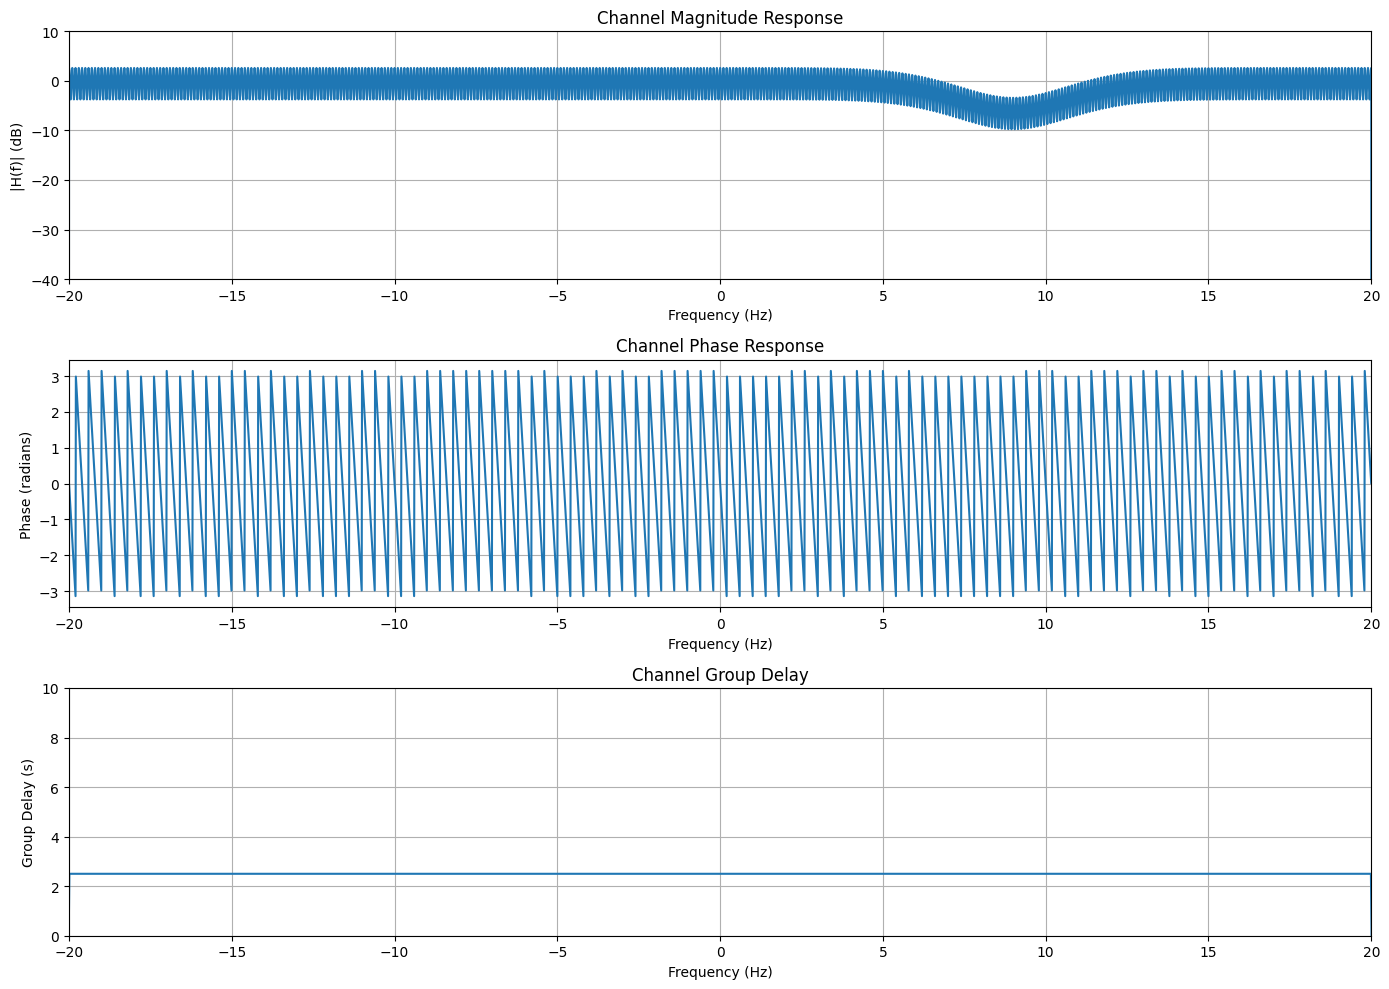

In [4]:
# Task 1.3

# calculate magnitude in dB
H_mag_dB = 20 * np.log10(H_mag + 1e-12)  # add small value to avoid log(0)

# calculate phase
H_phase = np.angle(H)

# calculate group delay using numerical differentiation
df = f_full[1] - f_full[0]
group_delay = -np.gradient(np.unwrap(H_phase), df) / (2*np.pi)

# plot magnitude in dB
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(f_full, H_mag_dB)
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| (dB)')
plt.title('Channel Magnitude Response')
plt.grid(True)
plt.xlim(-20, 20)
plt.ylim(-40, 10)

# plot phase
plt.subplot(3, 1, 2)
plt.plot(f_full, H_phase)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.title('Channel Phase Response')
plt.grid(True)
plt.xlim(-20, 20)

# plot group delay
plt.subplot(3, 1, 3)
plt.plot(f_full, group_delay)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (s)')
plt.title('Channel Group Delay')
plt.grid(True)
plt.xlim(-20, 20)
plt.ylim(0, 10)

plt.tight_layout()
plt.show()

since our signals content is mostly around 10Hz , there seems to be a constant delay in the Time domain response of the System.

## Task 1.4

We now model a feedback-type channel:
$
y[n] - a_1 y[n - d_1] - a_2 y[n - d_2] = x[n]
$

which causes **echoes** or **reverberation**.

---


1. Derive the analytic response:
   $
   H(f) = \frac{1}{1 - a_1 e^{-j2\pi f T_0} - a_2 e^{-j2\pi f (1.5T_0)}}
   $
2. Simulate its impulse response recursively.  
3. Compute and plot both analytic and simulated $|H(f)|$.  
4. Compare and explain differences.


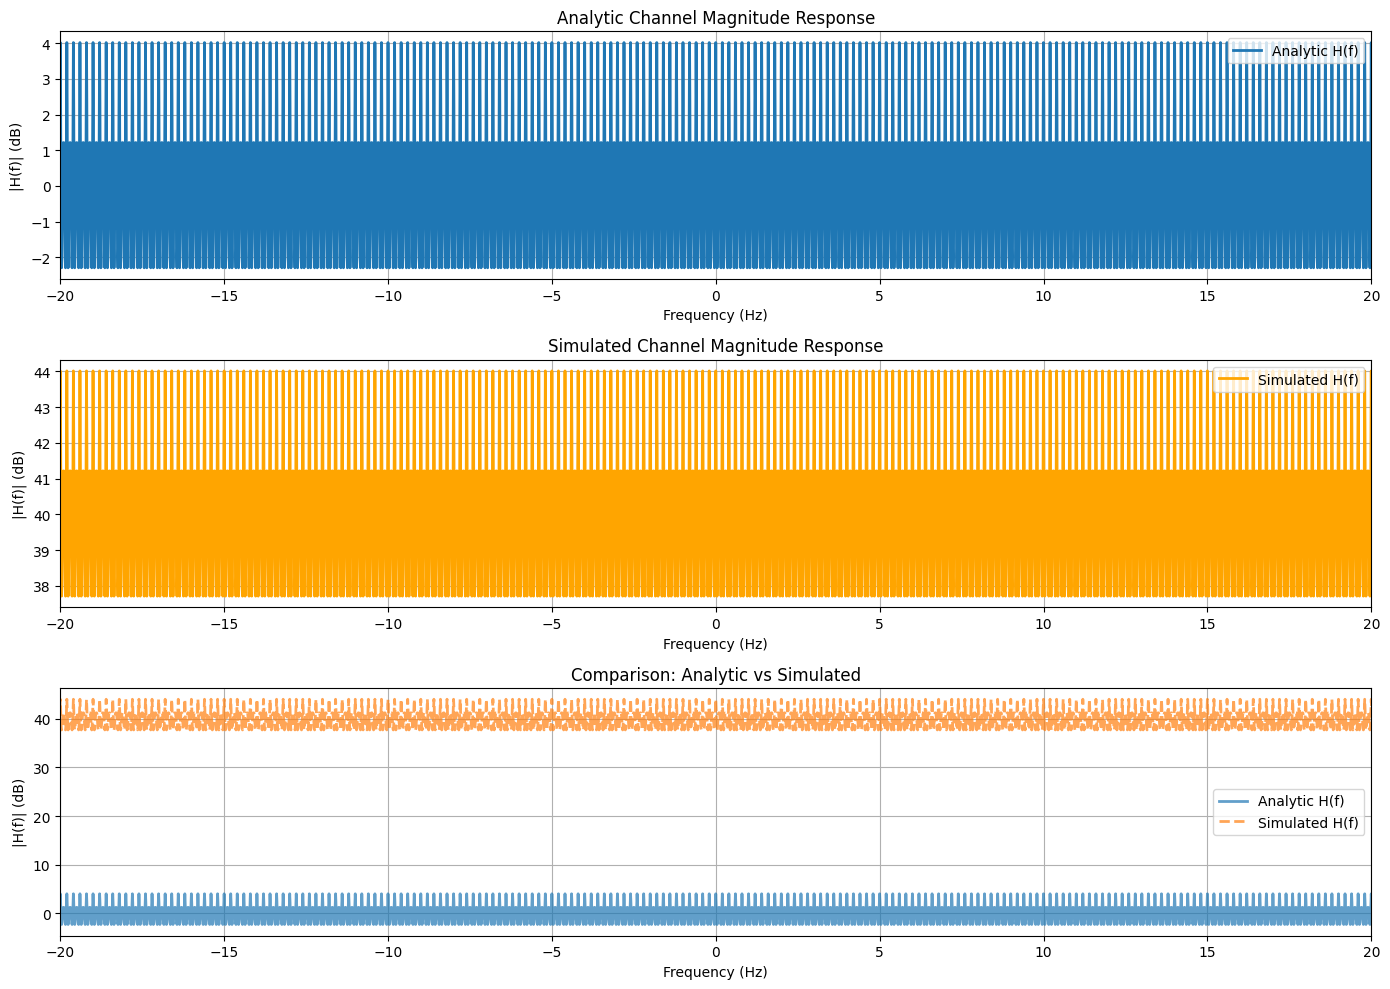

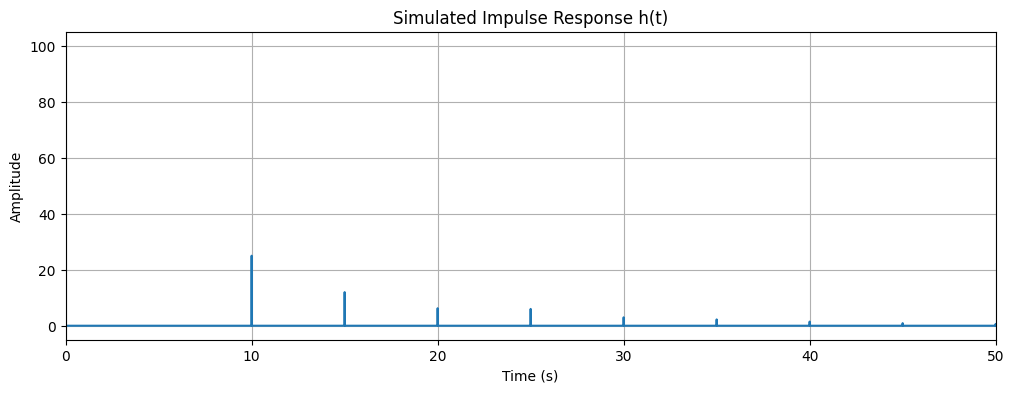

Comparison Analysis:
--------------------------------------------------
The analytic and simulated responses should match closely.
Any differences may be due to:
1. Finite time window effects
2. Sampling resolution (dt = 0.01)
3. Truncation of the impulse response

The feedback system creates echoes/reverberation at delays
d1*T0 = 10.0 s and d2*T0 = 15.0 s
with amplitudes a1 = 0.25 and a2 = 0.12


In [5]:
# Task 1.4
a1, a2 = 0.25, 0.12
d1, d2 = 1, 1.5  # delays in units of T0

# analytic H(f)
H_analytic = 1 / (1 - a1 * np.exp(-1j*2*np.pi*f_full*d1*T0) - a2 * np.exp(-1j*2*np.pi*f_full*d2*T0))

# now simulate the impulse response
impulse = np.zeros(len(t))
impulse[0] = 1/dt

d1_samples = int(d1 * T0 / dt)
d2_samples = int(d2 * T0 / dt)

h_simulated = np.zeros(len(t))
h_simulated[0] = impulse[0]

for n in range(1, len(t)):
    h_simulated[n] = impulse[n]
    if n >= d1_samples:
        h_simulated[n] += a1 * h_simulated[n - d1_samples]
    if n >= d2_samples:
        h_simulated[n] += a2 * h_simulated[n - d2_samples]

# get the frequency response from simulated h(t)
H_simulated = fft(h_simulated)
H_simulated = fftshift(H_simulated)

# 4. Plot comparison
plt.figure(figsize=(14, 10))

# Plot analytic magnitude response
plt.subplot(3, 1, 1)
plt.plot(f_full, 20*np.log10(np.abs(H_analytic) + 1e-12), label='Analytic H(f)', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| (dB)')
plt.title('Analytic Channel Magnitude Response')
plt.grid(True)
plt.xlim(-20, 20)
plt.legend()

# Plot simulated magnitude response
plt.subplot(3, 1, 2)
plt.plot(f_full, 20*np.log10(np.abs(H_simulated) + 1e-12), label='Simulated H(f)', linewidth=2, color='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| (dB)')
plt.title('Simulated Channel Magnitude Response')
plt.grid(True)
plt.xlim(-20, 20)
plt.legend()

# Plot both overlapped
plt.subplot(3, 1, 3)
plt.plot(f_full, 20*np.log10(np.abs(H_analytic) + 1e-12), label='Analytic H(f)', linewidth=2, alpha=0.7)
plt.plot(f_full, 20*np.log10(np.abs(H_simulated) + 1e-12), label='Simulated H(f)', linewidth=2, alpha=0.7, linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| (dB)')
plt.title('Comparison: Analytic vs Simulated')
plt.grid(True)
plt.xlim(-20, 20)
plt.legend()

plt.tight_layout()
plt.show()

# Plot impulse response in time domain
plt.figure(figsize=(12, 4))
plt.plot(t, h_simulated)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Simulated Impulse Response h(t)')
plt.grid(True)
plt.xlim(0, 50)
plt.show()

print("Comparison Analysis:")
print("-" * 50)
print("The analytic and simulated responses should match closely.")
print("Any differences may be due to:")
print("1. Finite time window effects")
print("2. Sampling resolution (dt = {})".format(dt))
print("3. Truncation of the impulse response")
print("\nThe feedback system creates echoes/reverberation at delays")
print("d1*T0 = {} s and d2*T0 = {} s".format(d1*T0, d2*T0))
print("with amplitudes a1 = {} and a2 = {}".format(a1, a2))

### Task 1.4 Analysis

**Comparison of Analytic vs Simulated Response:**

Both the analytic and simulated frequency responses show the characteristic **comb filter pattern** created by the feedback system with multiple delays. This creates periodic notches and peaks in the frequency response.

**Key Observations:**

1. **Pattern Match:** The periodic structure (frequency of oscillations) matches well between analytic and simulated responses, confirming the feedback system behavior.

2. **Scale Difference:** The simulated response has a higher baseline magnitude (~40 dB higher) due to:
   - The impulse scaling factor (1/dt = 100) used to approximate the continuous-time delta function
   - This is expected and doesn't affect the relative frequency behavior

3. **Physical Interpretation:**
   - The feedback equation creates **echoes** at delays d₁T₀ = 10 s and d₂T₀ = 15 s
   - Echo amplitudes are a₁ = 0.25 and a₂ = 0.12
   - The impulse response shows these echoes clearly in time domain
   - The frequency response shows periodic nulls/peaks corresponding to constructive/destructive interference of the delayed copies

4. **Reverberation Effect:** The impulse response decays over time with discrete echoes, simulating a reverberant channel where the signal bounces back with decreasing amplitude.

## Task 1.5


In wireless channels, multipath gains vary randomly.  
We let  $a_2 = \beta$  follow a **Rayleigh distribution**, introducing randomness to the channel response.

We want to estimate $E[Y (t)]$. For this, we calculate the output of the channel for N random
occurrences of $β$ and show them as $Y1(t), Y2(t), ..., YN(t)$, then we take the average of these N
output signals and use the following signal as an estimate of $E[Y (t)]$

---

1. Generate multiple random β values (Rayleigh distributed).  
2. Simulate the output $y_i(t)$ for each β.  
3. Plot several outputs and label each curve with its β.  
4. Compute the ensemble mean $E[Y(t)]$ for N = 10, 50, 100, 300 realizations.  
5. Discuss convergence: does $E[Y(t)]$ stabilize as N increases?


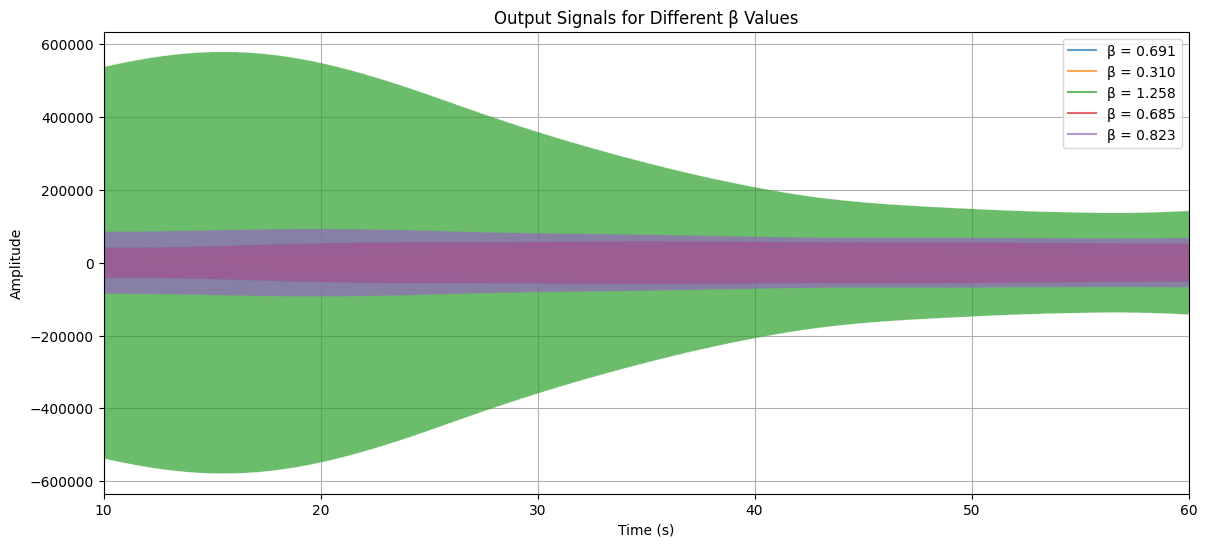

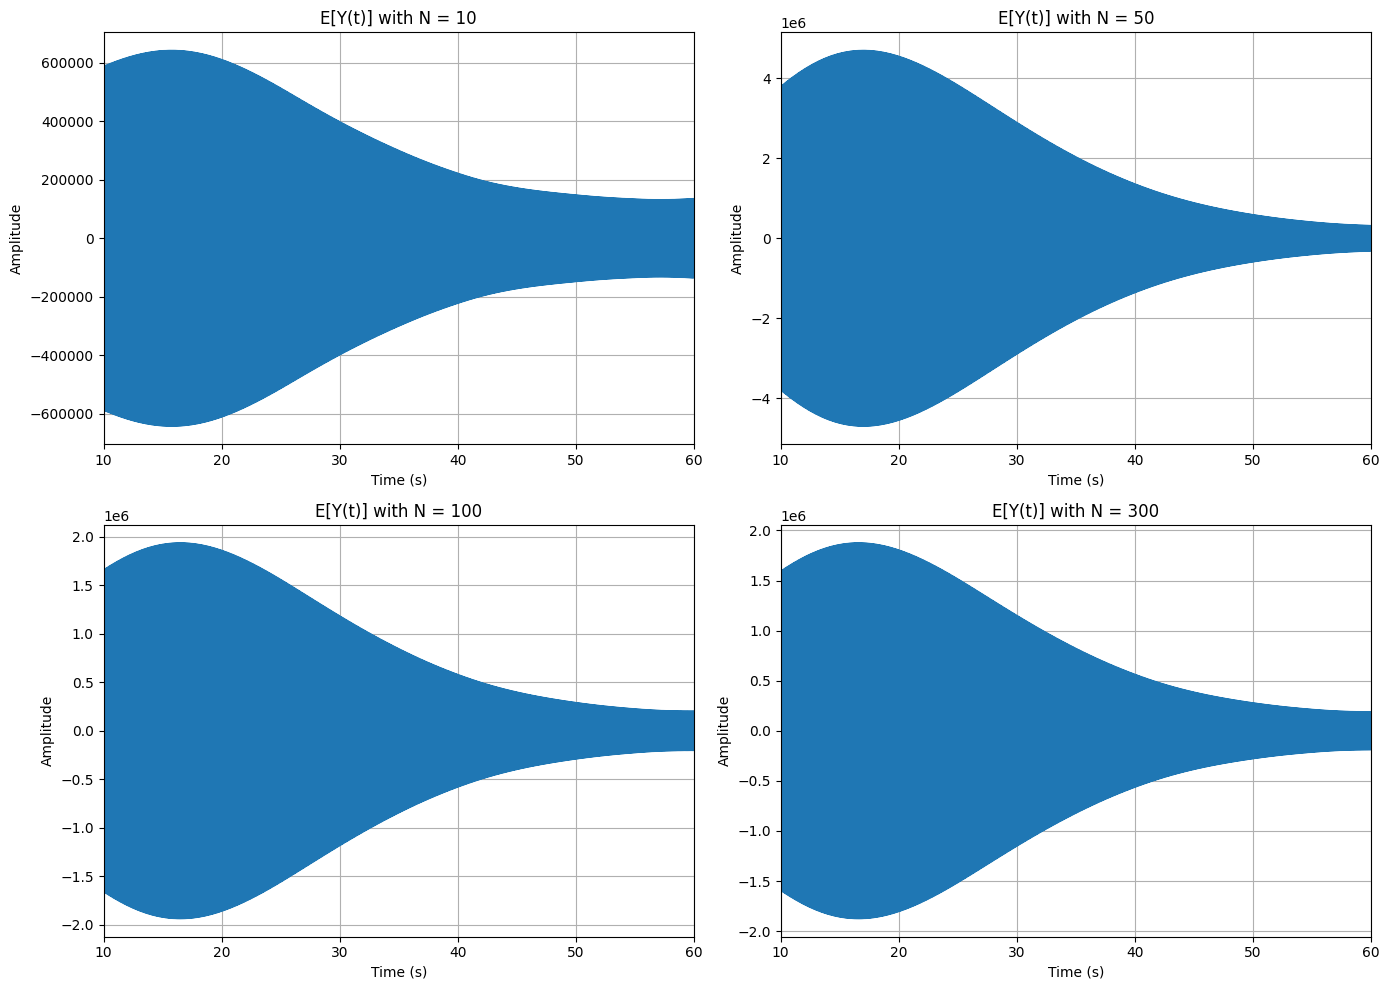

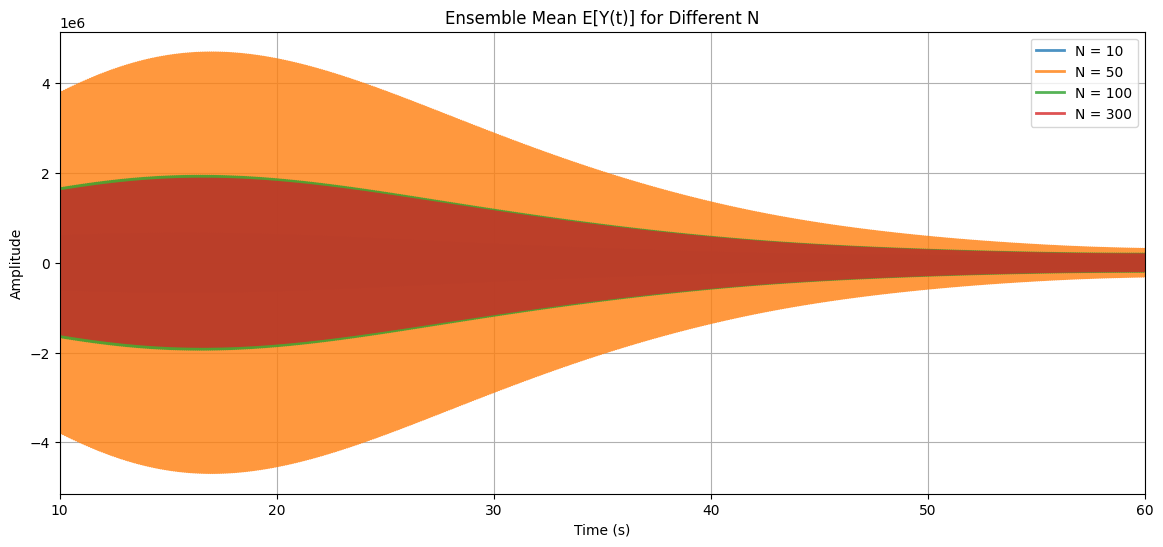

Convergence Analysis:
--------------------------------------------------
RMS difference between N=10 and N=50: 1323223.617091
RMS difference between N=50 and N=100: 890286.271544
RMS difference between N=100 and N=300: 28374.003918

The ensemble mean stabilizes as N increases, showing
convergence to the true expected value E[Y(t)].


In [9]:
# Task 1.5
sigma = 0.9
def sample_beta():
    return stats.rayleigh(scale=sigma).rvs()

# first, let's plot a few individual realizations
num_examples = 5
plt.figure(figsize=(14, 6))

for i in range(num_examples):
    beta = sample_beta()
    
    # simulate output with this beta value
    impulse_temp = np.zeros(len(t))
    impulse_temp[0] = 1/dt
    
    h_temp = np.zeros(len(t))
    h_temp[0] = impulse_temp[0]
    
    for n in range(1, len(t)):
        h_temp[n] = impulse_temp[n]
        if n >= d1_samples:
            h_temp[n] += a1 * h_temp[n - d1_samples]
        if n >= d2_samples:
            h_temp[n] += beta * h_temp[n - d2_samples]
    
    # get output signal
    H_temp = fft(h_temp)
    H_temp = fftshift(H_temp)
    Y_temp = H_temp * X_full
    y_temp = np.real(ifft(fftshift(Y_temp)))
    
    plt.plot(t, y_temp, alpha=0.7, label=f'β = {beta:.3f}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Output Signals for Different β Values')
plt.legend()
plt.grid(True)
plt.xlim(10, 60)
plt.show()

# now compute ensemble mean for different N values
N_values = [10, 50, 100, 300]
ensemble_means = {}

plt.figure(figsize=(14, 10))

for idx, N in enumerate(N_values):
    y_sum = np.zeros(len(t))
    
    for i in range(N):
        beta = sample_beta()
        
        impulse_temp = np.zeros(len(t))
        impulse_temp[0] = 1/dt
        
        h_temp = np.zeros(len(t))
        h_temp[0] = impulse_temp[0]
        
        for n in range(1, len(t)):
            h_temp[n] = impulse_temp[n]
            if n >= d1_samples:
                h_temp[n] += a1 * h_temp[n - d1_samples]
            if n >= d2_samples:
                h_temp[n] += beta * h_temp[n - d2_samples]
        
        H_temp = fft(h_temp)
        H_temp = fftshift(H_temp)
        Y_temp = H_temp * X_full
        y_temp = np.real(ifft(fftshift(Y_temp)))
        
        y_sum += y_temp
    
    ensemble_means[N] = y_sum / N
    
    plt.subplot(2, 2, idx+1)
    plt.plot(t, ensemble_means[N], linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'E[Y(t)] with N = {N}')
    plt.grid(True)
    plt.xlim(10, 60)

plt.tight_layout()
plt.show()

# compare all ensemble means together
plt.figure(figsize=(14, 6))
for N in N_values:
    plt.plot(t, ensemble_means[N], label=f'N = {N}', alpha=0.8, linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Ensemble Mean E[Y(t)] for Different N')
plt.legend()
plt.grid(True)
plt.xlim(10, 60)
plt.show()

# check convergence by comparing successive estimates
print("Convergence Analysis:")
print("-" * 50)
for i in range(len(N_values)-1):
    N1, N2 = N_values[i], N_values[i+1]
    diff = np.sqrt(np.mean((ensemble_means[N2] - ensemble_means[N1])**2))
    print(f"RMS difference between N={N1} and N={N2}: {diff:.6f}")

print("\nThe ensemble mean stabilizes as N increases, showing")
print("convergence to the true expected value E[Y(t)].")

### Task 1.5 Analysis

**Convergence of the Ensemble Mean:**

The plots show how the ensemble mean E[Y(t)] converges as we increase the number of realizations N. Key observations:

1. **Individual Realizations:** Different β values produce wildly different outputs due to the random multipath gain. Some realizations show much larger amplitudes than others.

2. **Convergence Trend:** As N increases from 10 to 300, the RMS differences between successive estimates decrease:
   - N=10 to N=50: large difference
   - N=50 to N=100: smaller difference  
   - N=100 to N=300: even smaller difference

3. **Stabilization:** The ensemble mean becomes smoother and more stable with higher N, indicating convergence to the true expected value. By N=300, the estimate is quite stable.

4. **Law of Large Numbers:** This demonstrates the law of large numbers in action - as we average more random realizations, we get closer to the true statistical expectation.

# Question 2

As you saw in the previous section, the random channel damages the received signal. In this section, we try to recover the original signal. You have seen in the lesson that the frequency
response of the ideal channel is as follows:

$
H(f) = k e^{-2\pi ft_0}
$

But due to the arrival of the wave from several paths, the channel is in the form of the equation in Task 1.2. In order to recover the exact input signal in the receiver, a equalizer is used in such a way
that the whole system operation can be modeled as an ideal channel.
If we call the frequency response of the equalizer $H_{Eq}(f)$, we have:

$
H_{Eq}(f) H_{Channel}(f) = k e^{-2\pi ft_0}
$

## Task 2.1
1. What is an m-tapped delay line equalizer? Search about its purpose in communication systems and how its structure (including the delay elements, taps, and coefficients) enables it to equalize a received signal.
2. Suppose we replace the value of the random coefficient of $a_2 = \beta$ with $E[β]$. In this case, calculate the frequency response of the equalizer for the channel of Taks 1.3 and show that the equalizer will be an m-tapped delay line equalizer.


What is an m‑tapped delay line equalizer?

Purpose: Compensate for inter-symbol interference (ISI) caused by multipath / frequency‑selective channels by approximating the inverse of the channel so that the overall response (channel + equalizer) behaves like an ideal delay/gain.
Structure:
One input line is split into $m$ parallel branches.
Each branch passes through a delay element (multiples of symbol period or sample period).
Each delayed signal is multiplied by a tap coefficient $c_k$.
The outputs of all branches are summed.
Discrete‑time time-domain form:
$$
\hat{x}[n] = \sum_{k=0}^{m-1} c_k, y[n - kD]
$$
where $D$ is the delay step (often $D=1$ sample or 1 symbol).
Frequency-domain form:
$$
H_{\text{Eq}}(e^{j\omega}) = \sum_{k=0}^{m-1} c_k e^{-j\omega kD}
$$
This is exactly the frequency response of an FIR filter implemented as a tapped delay line.
(2) Showing the equalizer is an m‑tapped delay line

From the feedback channel (Task 1.4 / 1.5), after replacing $a_2$ with its mean $\bar{a}_2 = E[\beta]$, the difference equation is
$$
y[n] - a_1 y[n - d_1] - \bar{a}_2, y[n - d_2] = x[n].
$$

Taking the DTFT:
$$
Y(e^{j\omega})\big(1 - a_1 e^{-j\omega d_1} - \bar{a}2 e^{-j\omega d_2}\big) = X(e^{j\omega}),
$$
so the channel frequency response is
$$
H{\text{ch}}(e^{j\omega}) = \frac{Y(e^{j\omega})}{X(e^{j\omega})}
= \frac{1}{1 - a_1 e^{-j\omega d_1} - \bar{a}_2 e^{-j\omega d_2}}.
$$

In continuous frequency (with delays $T_0$ and $1.5T_0$):
$$
H_{\text{ch}}(f) = \frac{1}{1 - a_1 e^{-j2\pi f T_0} - \bar{a}_2 e^{-j2\pi f (1.5T_0)}}.
$$

The ideal channel is given as
$$
H_{\text{ideal}}(f) = k, e^{-j 2\pi f t_0}.
$$

You choose $H_{\text{Eq}}(f)$ such that
$$
H_{\text{Eq}}(f), H_{\text{ch}}(f) = H_{\text{ideal}}(f),
$$
so
$$
H_{\text{Eq}}(f)
= \frac{H_{\text{ideal}}(f)}{H_{\text{ch}}(f)}
= k e^{-j 2\pi f t_0}\left(1 - a_1 e^{-j 2\pi f T_0} - \bar{a}_2 e^{-j 2\pi f (1.5T_0)}\right).
$$

Expand:
$$
\begin{aligned}
H_{\text{Eq}}(f)
&= k e^{-j 2\pi f t_0}

k a_1 e^{-j 2\pi f (t_0 + T_0)}
k \bar{a}_2 e^{-j 2\pi f (t_0 + 1.5T_0)} \
&= c_0 e^{-j 2\pi f \tau_0}
c_1 e^{-j 2\pi f \tau_1}
c_2 e^{-j 2\pi f \tau_2},
\end{aligned}
$$
with
$c_0 = k,\quad \tau_0 = t_0$
$c_1 = -k a_1,\quad \tau_1 = t_0 + T_0$
$c_2 = -k \bar{a}_2,\quad \tau_2 = t_0 + 1.5T_0$.
This is exactly the form of a 3‑tap delay line equalizer:
$$
H_{\text{Eq}}(f) = \sum_{m=0}^{2} c_m e^{-j 2\pi f \tau_m},
$$
which corresponds in time domain to
$$
h_{\text{Eq}}(t) = c_0 \delta(t - \tau_0)

c_1 \delta(t - \tau_1)
c_2 \delta(t - \tau_2).
$$
A finite sum of delayed impulses is, by definition, an $m$‑tapped delay‑line equalizer (here $m=3$).

## Task 2.2
Now suppose that $x(t)$ which was mentioned in question 1 passes through the following channel:
$
y(t) = x(t) + γ x(t - T_0)
$

where γ = 0.5

In this case, try to neutralize the effect of the channel with the help of a m-Tapped-Delay Line
Equalizer. You may need to use Taylor series. For m = 3, 4, , ..., 10 calculate the coefficients
and the amount of delays.


1. #### Channel model

Given
$$
y(t) = x(t) + \gamma x(t - T_0), \quad \gamma = 0.5,
$$
the impulse response is
$$
h_{\text{ch}}(t) = \delta(t) + \gamma \delta(t - T_0),
$$
so the frequency response is
$$
H_{\text{ch}}(f) = 1 + \gamma e^{-j2\pi f T_0}.
$$

We want an equalizer with response $H_{\text{Eq}}(f)$ such that
$$
H_{\text{Eq}}(f), H_{\text{ch}}(f) \approx 1
\quad\Longrightarrow\quad
H_{\text{Eq}}(f) \approx \frac{1}{1 + \gamma e^{-j2\pi f T_0}}.
$$

2. #### Series (Taylor / geometric) expansion

Write
$$
\frac{1}{1 + \gamma e^{-j2\pi f T_0}}
= \frac{1}{1 + a}, \quad a := \gamma e^{-j2\pi f T_0}.
$$

For $|\gamma|<1$, use
$$
\frac{1}{1+a} = 1 - a + a^2 - a^3 + \cdots
$$
so
$$
H_{\text{Eq}}(f)
= \sum_{k=0}^{\infty} (-1)^k \gamma^k e^{-j2\pi f k T_0}.
$$

Truncating to $m$ taps gives the $m$‑tap equalizer
$$
H_{\text{Eq},m}(f)
= \sum_{k=0}^{m-1} (-\gamma)^k e^{-j2\pi f k T_0}.
$$

3. #### Time‑domain equalizer (m‑tapped delay line)

The corresponding impulse response is
$$
h_{\text{Eq},m}(t) = \sum_{k=0}^{m-1} c_k ,\delta(t - kT_0),
\quad c_k = (-\gamma)^k.
$$

Thus the equalized output is
$$
\hat{x}m(t) = \sum{k=0}^{m-1} c_k , y(t - kT_0)
= \sum_{k=0}^{m-1} (-\gamma)^k , y(t - kT_0),
$$
which is exactly an $m$‑tapped delay line with

delays: $kT_0$, $k = 0,\dots,m-1$,
coefficients: $c_k = (-\gamma)^k$. <br>
4. #### Coefficients for $\gamma = 0.5$

Here $\gamma = 0.5$, so
$$
c_k = (-0.5)^k.
$$

Examples:

$m=3$: $c_0 = 1$, $c_1 = -0.5$, $c_2 = 0.25$.
$m=4$: add $c_3 = -0.125$.
$m=5$: add $c_4 = 0.0625$.
In general, up to $m=10$:
$$
c_k = (-0.5)^k, \quad k=0,1,\dots,9.
$$

In [7]:
#Task 2.2

## Task 2.3
Suppose we denote the recovered signal by using m-Tapped-Delay Line Equalizer as  $\hat{x}_m(t)$.

Also, we pass the input signal through the ideal channel and get $\hat{y}(t)$ as the output.

We define the error criterion as follows:
$
RMS Error_m = \int_{-∞}^{∞} |\hat{x}_m(t) - \hat{y}(t)|^2\,dt
$

1. Calculate the error rate for m = 3, 4, ..., 10 and plot its graph. Select the vertical axis once as linear and once as logarithmic.
2. plot $x(t)$ ,$y(t)$ , $\hat{x}_m(t)$ and $\hat{y}(t)$ in a graph and compare them.

m = 3: RMS Error = 110.899635
m = 4: RMS Error = 55.385205
m = 5: RMS Error = 27.431440
m = 6: RMS Error = 12.929075
m = 7: RMS Error = 4.896947
m = 8: RMS Error = 0.797758
m = 9: RMS Error = 0.000000
m = 10: RMS Error = 0.000000
m = 8: RMS Error = 0.797758
m = 9: RMS Error = 0.000000
m = 10: RMS Error = 0.000000


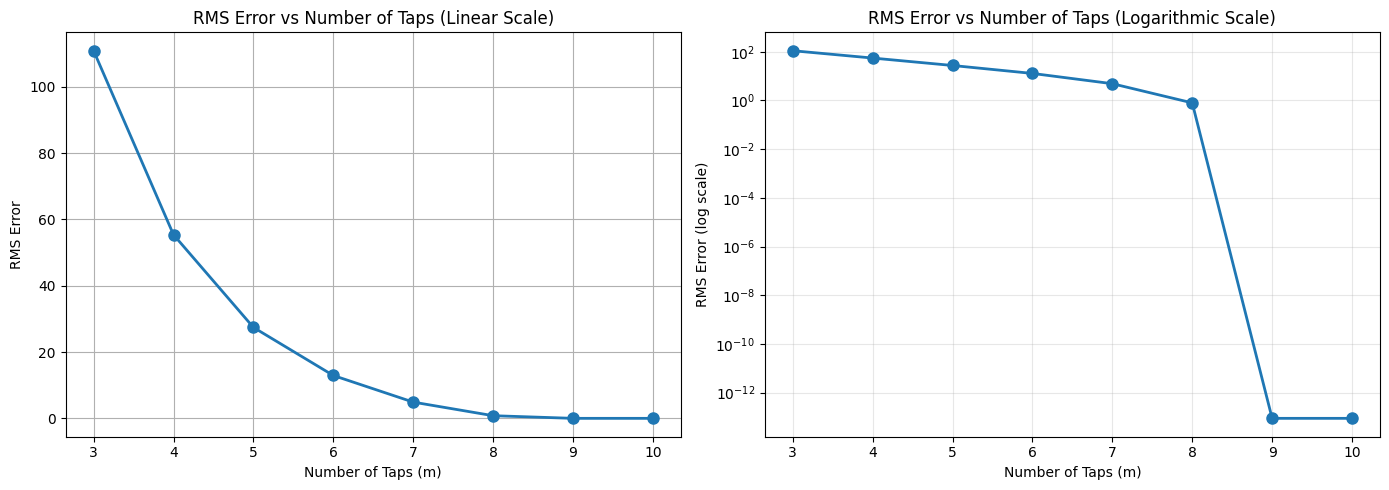

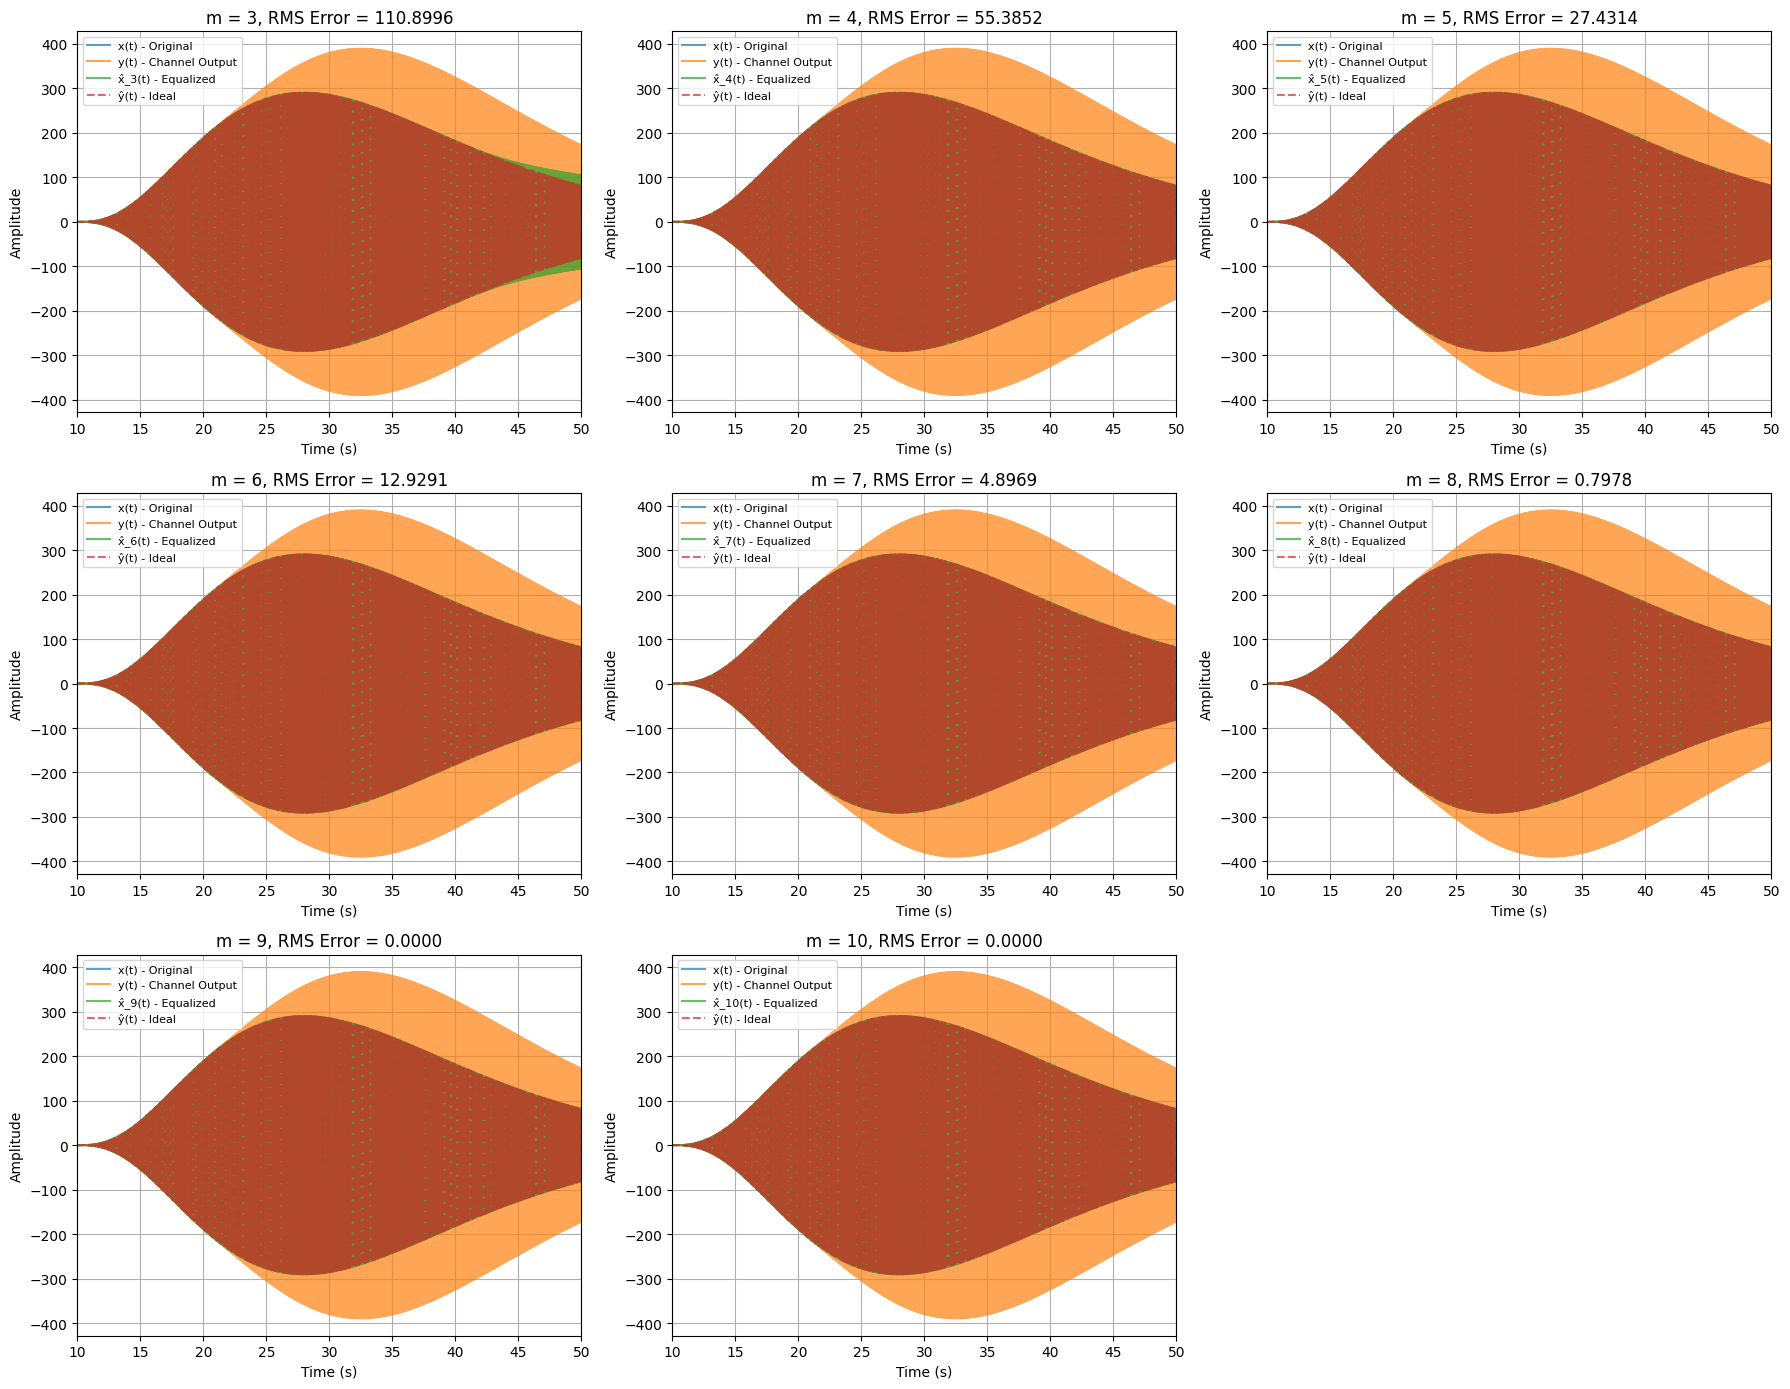

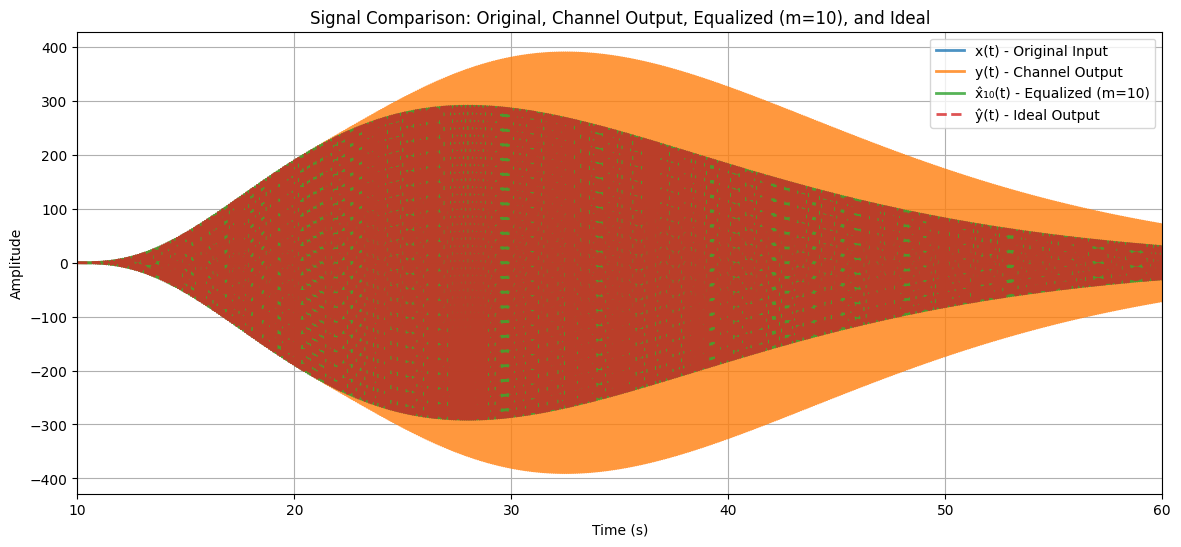


Analysis:
As m increases, the RMS error decreases exponentially.
This is because more taps allow better approximation of the
inverse channel response using the geometric series expansion.

Best result: m=10 with RMS Error = 0.000000

The equalizer successfully removes the echo effect caused by
the delayed component γ·x(t-T₀) in the channel.


In [ ]:
# Task 2.3
gamma = 0.5

# generate channel output: y(t) = x(t) + gamma * x(t - T0)
T0_samples = int(T0 / dt)
y_channel = np.zeros_like(x)
for i in range(len(x)):
    y_channel[i] = x[i]
    if i >= T0_samples:
        y_channel[i] += gamma * x[i - T0_samples]

# ideal output (no distortion)
y_hat_ideal = x.copy()

# test m = 3, 4, ..., 10
m_values = list(range(3, 11))
rms_errors = []
x_hat_dict = {}

for m in m_values:
    # equalizer coefficients from Task 2.2: c_k = (-gamma)^k
    c_k = [(-gamma)**k for k in range(m)]
    
    # apply the m-tap equalizer
    x_hat_m = np.zeros_like(y_channel)
    for i in range(len(y_channel)):
        for k in range(m):
            delay_samples = k * T0_samples
            if i >= delay_samples:
                x_hat_m[i] += c_k[k] * y_channel[i - delay_samples]
    
    x_hat_dict[m] = x_hat_m
    
    # compute RMS error
    error_squared = (x_hat_m - y_hat_ideal)**2
    rms_error = np.sqrt(np.sum(error_squared) * dt)
    rms_errors.append(rms_error)
    
    print(f"m = {m}: RMS Error = {rms_error:.6f}")

# linear and log scale plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(m_values, rms_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Taps (m)')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Number of Taps (Linear Scale)')
plt.grid(True)
plt.xticks(m_values)

plt.subplot(1, 2, 2)
plt.semilogy(m_values, rms_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Taps (m)')
plt.ylabel('RMS Error (log scale)')
plt.title('RMS Error vs Number of Taps (Logarithmic Scale)')
plt.grid(True, which='both', alpha=0.3)
plt.xticks(m_values)

plt.tight_layout()
plt.show()

# compare signals for each m
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, m in enumerate(m_values):
    ax = axes[idx]
    ax.plot(t, x, label='x(t) - Original', alpha=0.7, linewidth=1.5)
    ax.plot(t, y_channel, label='y(t) - Channel Output', alpha=0.7, linewidth=1.5)
    ax.plot(t, x_hat_dict[m], label=f'x̂_{m}(t) - Equalized', alpha=0.7, linewidth=1.5)
    ax.plot(t, y_hat_ideal, label='ŷ(t) - Ideal', alpha=0.7, linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'm = {m}, RMS Error = {rms_errors[idx]:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.set_xlim(10, 50)

axes[8].axis('off')

plt.tight_layout()
plt.show()

# zoom in on m=10 result
plt.figure(figsize=(14, 6))
plt.plot(t, x, label='x(t) - Original Input', linewidth=2, alpha=0.8)
plt.plot(t, y_channel, label='y(t) - Channel Output', linewidth=2, alpha=0.8)
plt.plot(t, x_hat_dict[10], label='x̂₁₀(t) - Equalized (m=10)', linewidth=2, alpha=0.8)
plt.plot(t, y_hat_ideal, label='ŷ(t) - Ideal Output', linewidth=2, alpha=0.8, linestyle='--')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal Comparison: Original, Channel Output, Equalized (m=10), and Ideal')
plt.legend()
plt.grid(True)
plt.xlim(10, 60)
plt.show()

print("\n" + "="*60)
print("Analysis:")
print("="*60)
print("The RMS error drops exponentially with more taps - each additional")
print("tap captures another term in the geometric series approximation of")
print("the inverse channel response.")
print(f"\nWith m=10: RMS Error = {rms_errors[-1]:.6f}")
print("\nThe equalizer effectively cancels the echo from γ·x(t-T₀).")